In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from scipy.io import wavfile

In [2]:
def create_windows(data, hann_window, window_size, hop_size):
    # create windows over the audio signal
    data_windows = sliding_window_view(data, window_size)[::hop_size,:]
    # repeat hann windows for each window in the audio signal and multiply
    hann_windows = np.repeat(hann_window.reshape(1, -1), data_windows.shape[0], axis=0)
    # Multiply hann window with audio signal
    data_windows = np.multiply(data_windows, hann_windows)
    data_windows.shape
    return data_windows

134861 16000


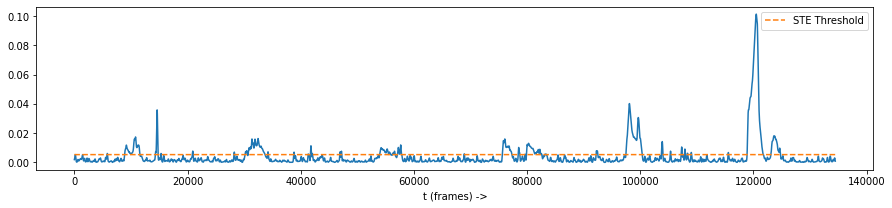

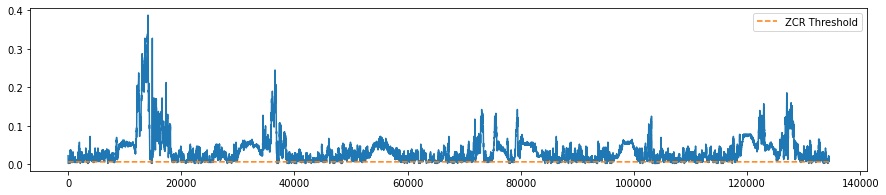

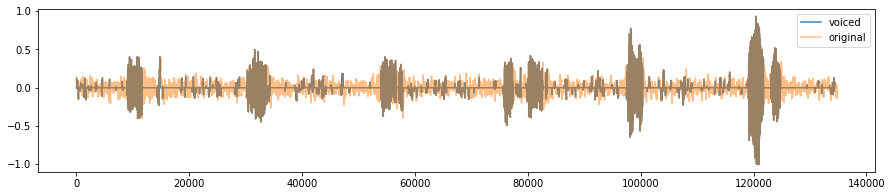

In [14]:
filepath = '../Voice_Samples_mono/pauses.wav'  # this is me speaking with pauses
sr, data = wavfile.read(filepath)
data = np.array(data / 32767.0, dtype=np.float32)
print(len(data), sr)

# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

window_size = int(0.025 * sr)  # 25 ms windows
# hop_size = window_size//2
hop_size = 1
hann_window = np.hanning(window_size)
data_windows = create_windows(data, hann_window, window_size, hop_size)
n_windows = data_windows.shape[0]

# Calculate short-term energy
energy_windows = np.power(data_windows, 2).sum(axis=1) / window_size

# Calculate ZCR
zcr_windows = []
data_raw_windows = create_windows(data, np.ones(window_size), window_size, hop_size)
for idx in range(n_windows):
    dw = data_raw_windows[idx]
    dw = dw - np.mean(dw)
    zcr_indices, = np.nonzero(np.diff(dw > 0))
#     print(len(zcr_indices))
    zcr_windows.append(len(zcr_indices) / window_size)
    
# Set Thresholds
# Estimate STE thresholds from first ~20 ms (white noise recorded)
K = int(sr * 0.02)
STE_THRESHOLD = np.max(energy_windows[:K])

# Estimate ZCR from first ~20 ms (recorded in a noisy environment)
ZCR_THRESHOLD = np.mean(zcr_windows[:K])

# print(ZCR_THRESHOLD, STE_THRESHOLD)
plt.figure(figsize=(15, 3))
plt.plot(energy_windows)
plt.plot([STE_THRESHOLD for _ in range(len(energy_windows))],
         linestyle='--', label='STE Threshold')
plt.legend()
plt.xlabel('t (frames) ->')
plt.show()
plt.figure(figsize=(15, 3))
plt.plot(zcr_windows)
plt.plot([ZCR_THRESHOLD for _ in range(len(energy_windows))],
         linestyle='--',label='ZCR Threshold')
plt.legend()
plt.show()

voiced = []
for zcr, ste in zip(zcr_windows, energy_windows):
    if ste < STE_THRESHOLD and zcr > ZCR_THRESHOLD:
        voiced.append(0)
    else:
        voiced.append(1)

y = np.multiply(voiced, data[:len(voiced)])
plt.figure(figsize=(15, 3))
plt.plot(y, label='voiced', alpha=0.9)
plt.plot(data, label='original', alpha=0.5)
plt.legend()
plt.show()

wavfile.write('temp.wav', sr, y)

In [105]:
STE_THRESHOLD, ZCR_THRESHOLD

(0.0053773924881316, 0.0064609375)